<a href="https://colab.research.google.com/github/EdgarGM20/ML-NLP/blob/main/S2TC1_RandomForests_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

data.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [3]:
# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
318288,2014,39988,0,0,0,0,0,1,0
333638,2007,38904,0,0,0,0,1,0,0
234716,2016,29607,0,0,0,0,0,1,0
208752,2014,50756,0,0,0,0,0,1,0
348892,2017,10506,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
218085,2010,84057,0,0,0,0,1,0,0
198455,2012,93770,0,1,0,0,0,0,0
205572,2010,88644,0,0,1,0,0,0,0
33541,2015,26180,0,0,0,0,0,1,0


### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [6]:
# Celda 1
# Celda 4
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
#j, split, gain = best_split(XTotal, yTotal, 5)
#j, split, gain

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

import numpy as np
from sklearn.metrics import accuracy_score
# Aplicación de la función tree_grow
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=10)
#print("Árbol generado: \n", tree)

# Ejecución de función tree_predict
y_pred = tree_predict(X_test, tree, False)
acc_dt = accuracy_score(y_test, y_pred)
print('\nAccuracy con DT: ', acc_dt )
#print('\ny_pred con DT: ', y_pred)


Accuracy con DT:  0.8830831408775982


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [7]:
# Celda 2

def mbagging(n_B, X_train, X_test, y_train, y_test):
  import numpy as np
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.metrics import accuracy_score

  # Creación de 10 muestras de bootstrap
  # np.random.seed(1)
  n_samples = X_train.shape[0] # Número de muestras
  samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B + 1)]

  # Definición del modelo usando DecisionTreeRegressor de sklearn
  treeclas = DecisionTreeClassifier(max_depth=None, random_state=123)

  # DataFrame para guardar las predicciones de cada árbol
  y_pred_df = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

  for i, sample in enumerate(samples):
    Xtrain = X_train.iloc[sample]
    ytrain = y_train.iloc[sample]
    treeclas.fit(Xtrain, ytrain)
    y_pred_df.iloc[:,i] = treeclas.predict(X_test)

  y_pred_bag = (y_pred_df.sum(axis=1) >= (n_B / 2)).astype(np.int)

  return y_pred_df, y_pred_bag

n_B = 10
y_pred_df, y_pred_mbag = mbagging(n_B, X_train, X_test, y_train, y_test)

# Desempeño de cada árbol
for i in range(n_B):
  print('El árbol', i, 'tiene un accuracy de: ', accuracy_score(y_test, y_pred_df.iloc[:,i]))

acc_mbag = accuracy_score(y_test, y_pred_mbag)
print('\nAccuracy_bagging: ', acc_mbag)

El árbol 0 tiene un accuracy de:  0.8334295612009238
El árbol 1 tiene un accuracy de:  0.8458429561200924
El árbol 2 tiene un accuracy de:  0.836027713625866
El árbol 3 tiene un accuracy de:  0.8371824480369515
El árbol 4 tiene un accuracy de:  0.8420900692840647
El árbol 5 tiene un accuracy de:  0.8366050808314087
El árbol 6 tiene un accuracy de:  0.8420900692840647
El árbol 7 tiene un accuracy de:  0.8308314087759815
El árbol 8 tiene un accuracy de:  0.8394919168591224
El árbol 9 tiene un accuracy de:  0.8340069284064665

Accuracy_bagging:  0.8556581986143187


**Conclusión**

El accuracy del bagging de los 10 árboles (0.855) mejora los accuracy obtenidos individualmente por cada uno de los árboles (el máximo obtenido es de 0.846)

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [21]:
# Celda 3

# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

n_features = X_train.shape[1]
bagclas = BaggingClassifier(DecisionTreeClassifier(max_features='log2'), n_estimators=10, 
                          bootstrap=True, oob_score=True, random_state=1) # , max_features=np.log(n_features)

# Entrenamiento del modelo con set de entrenamiento y predicción en el set de test
bagclas.fit(X_train, y_train)
y_pred_lbag = bagclas.predict(X_test)

acc_bag = accuracy_score(y_test, y_pred_lbag)

print('\nAccuracy_bagging: ', acc_bag)


Accuracy_bagging:  0.8429561200923787


**Conclusión**

Al hacer uso de la librería de bagging con los parámetros establecidos: 10 estimadores y el número máximo de características igual a la raíz, no se obtienen mejores resultados a los ya obtenidos anteriormente.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [9]:
# Celda 4
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier(random_state=0)

# Entrenamiento del modelo con set de entrenamiento y predicción en el set de test
clf.fit(X_train, y_train)
y_pred_lRF = clf.predict(X_test)

acc_RF = accuracy_score(y_test, y_pred_lRF)
print('\nAccuracy_RF: ', acc_RF)

#Impresión de desempeño del modelo usando la función cross_val_score  (más detalles en https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
#pd.Series(cross_val_score(clf, X, y, cv=10)).describe()


Accuracy_RF:  0.8443995381062356


**Conclusión**

Al hacer uso del modelo de Random Forest sin calibrar se observa que el accuracy obtenido aún no obtiene una mejora a los modelos ya definidos anteriormente.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

Text(0, 0.5, 'Accuracy')

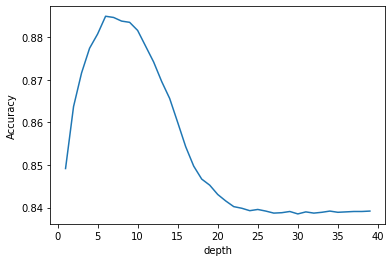

In [10]:
# Celda 5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calibración de max_depth
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
depth_range = range(1, 40, 1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for depth in depth_range:
  clf = RandomForestClassifier(max_depth=depth, random_state=1, n_jobs=-1) #
  accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(depth_range, accuracy_scores)
plt.xlabel('depth')
plt.ylabel('Accuracy')

max_acc_depth:  0.884992853739876
depth_max_acc:  6


Text(0, 0.5, 'Accuracy')

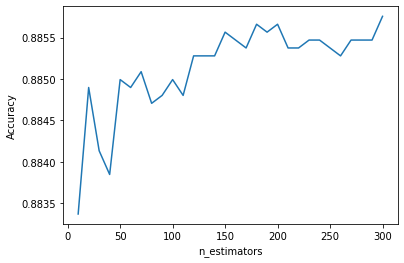

In [11]:
# Calibración de n_estimators
max_acc_depth = np.max(accuracy_scores)
depth_max_acc = depth_range[accuracy_scores.index(max_acc_depth)]
print("max_acc_depth: ", max_acc_depth)
print("depth_max_acc: ", depth_max_acc)

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
  clf = RandomForestClassifier(max_depth=depth_max_acc, n_estimators=estimator, random_state=1, n_jobs=-1) #
  accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

max_acc:  0.8857551214864221
n_est_max_acc:  300
feature_cols:  9


Text(0, 0.5, 'Accuracy')

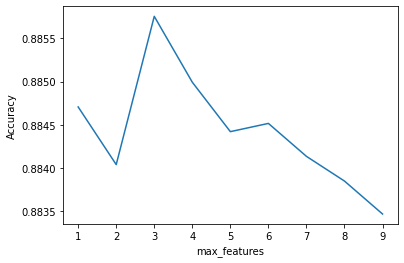

In [12]:
# Calibracióm max_features
max_acc_est = np.max(accuracy_scores)
n_est_max_acc = estimator_range[accuracy_scores.index(max_acc_est)]
print("max_acc: ", max_acc_est)
print("n_est_max_acc: ", n_est_max_acc)

# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_cols = X_train.shape[1]
print("feature_cols: ", feature_cols)
feature_range = range(1, feature_cols+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(max_depth=depth_max_acc, n_estimators=n_est_max_acc, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [13]:
# Implementación de un Random Forest con los mejores parámetros
max_acc_feat = np.max(accuracy_scores)
feat_max_acc = feature_range[accuracy_scores.index(max_acc_feat)]
print("max_acc: ", max_acc_feat)
print("feat_max_acc: ", feat_max_acc)
print("n_est_max_acc: ", n_est_max_acc)
print("depth_max_acc: ", depth_max_acc)

# Definición del modelo con los parámetros max_depth, max_features y n_estimators 
clf = RandomForestClassifier(max_depth=depth_max_acc, n_estimators=n_est_max_acc, max_features=feat_max_acc, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)

# Entrenamiento del modelo con set de entrenamiento y predicción en el set de test
y_pred_best_RF = clf.predict(X_test)
acc_RF_cal = accuracy_score(y_test, y_pred_best_RF)
print('\nAccuracy_RF: ', acc_RF_cal)

# Impresión de resultados de desemepeño del modelo
feature_cols_name = X_test.columns
pd.DataFrame({'feature':feature_cols_name, 'importance':clf.feature_importances_}).sort_values('importance')



max_acc:  0.8857551214864221
feat_max_acc:  3
n_est_max_acc:  300
depth_max_acc:  6

Accuracy_RF:  0.8865473441108545


,feature,importance
5,M_CamryL,0.003685
4,M_CamryBase,0.004078
2,M_Camry,0.005084
6,M_CamryLE,0.008489
8,M_CamryXLE,0.011274
7,M_CamrySE,0.027890
3,M_Camry4dr,0.084715
0,Year,0.402455
1,Mileage,0.452329


**Conclusión**

Al calibrar los parámetros: máximo número de características, el número de estimadores y la máxima profundidad en cada árbol se obtiene una mejora significativa a los modelos ya definidos anteriormente. Por otro lado, al variar la profundidad de los arboles se observa que a partir de cierta cantidad el accuracy se desmejora. En cuanto al número de estimadores, se observa que el accuracy va aumentando hasta llegar a una estabilidad donde no hay una mejora sustancial. Finalmente, al variar el número de características, se observa que que hay un óptimo alrededor de 3 que viene siendo la raíz cuadrada del número total de características de este problema en particular.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [14]:
# Celda 6
# Importación y definición de modelo XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

clf = XGBClassifier()
clf

# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf.fit(X_train, y_train)
y_pred_XG_ = clf.predict(X_test)

acc_XG = accuracy_score(y_pred_XG_, y_test.values)
print('\nAccuracy_XG: ', acc_XG)
print('f1_score_XG: ', f1_score(y_pred_XG_, y_test.values))

# Impresión de resultados de desemepeño del modelo
feature_cols_name = X_test.columns
pd.DataFrame({'feature':feature_cols_name, 'importance':clf.feature_importances_}).sort_values('importance')


Accuracy_XG:  0.8877020785219399
f1_score_XG:  0.9070045421945971


,feature,importance
3,M_Camry4dr,0.000000
4,M_CamryBase,0.004520
7,M_CamrySE,0.007249
5,M_CamryL,0.031684
2,M_Camry,0.042683
8,M_CamryXLE,0.054284
6,M_CamryLE,0.092740
1,Mileage,0.312486
0,Year,0.454355


**Conclusión**

Al ejecutar el módelo de XGBOOST sin calibrar se obtiene un accuracy similar al obtenido por el Random Forest calibrado, por lo que se observa la robustéz de este para encontrar el mejor modelo que se acomoda a los datos.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

max_acc:  0.8854692710814673
feat_max_acc:  0.09


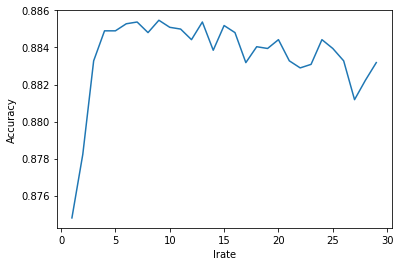

In [15]:
# Celda 7
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calibración de learning_rate
# Creación de lista de valores para iterar sobre diferentes valores de learning_rate
learning_range = range(1, 30, 1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for lrate in learning_range:
  clf = XGBClassifier(learning_rate = lrate/100, random_state=1)
  accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(learning_range, accuracy_scores)
plt.xlabel('lrate')
plt.ylabel('Accuracy')

# Mejores parámetros
max_acc_lrate = np.max(accuracy_scores)
lrate_max_acc = learning_range[accuracy_scores.index(max_acc_lrate)]/100
print("max_acc: ", max_acc_lrate)
print("feat_max_acc: ", lrate_max_acc)

max_acc:  0.8854692710814673
pgamma_max_acc:  0


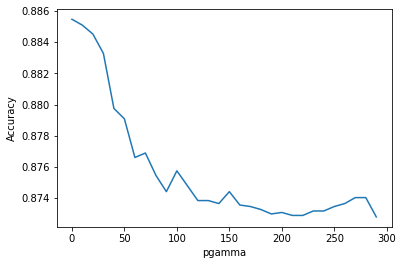

In [16]:
# Calibración de gamma
# Creación de lista de valores para iterar sobre diferentes valores de gamma
gamma_range = range(0, 300, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for pgamma in gamma_range:
  clf = XGBClassifier(learning_rate = lrate_max_acc, gamma = pgamma, random_state=1)
  accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('pgamma')
plt.ylabel('Accuracy')

# Mejores parámetros
max_acc_pgamma = np.max(accuracy_scores)
pgamma_max_acc = gamma_range[accuracy_scores.index(max_acc_pgamma)]
print("max_acc: ", max_acc_pgamma)
print("pgamma_max_acc: ", pgamma_max_acc)

max_acc:  0.8852787041448309
colsample_max_acc:  0.41


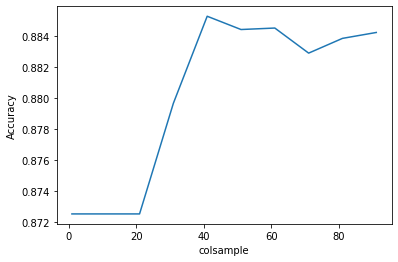

In [17]:
# Calibración de colsample_bytree
# Creación de lista de valores para iterar sobre diferentes valores de colsample_bytree
colsample_range = range(1, 100, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for csample in colsample_range:
  clf = XGBClassifier(learning_rate = lrate_max_acc, gamma = pgamma_max_acc, colsample_bytree = csample/100, random_state=1)
  accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(colsample_range, accuracy_scores)
plt.xlabel('colsample')
plt.ylabel('Accuracy')

# Mejores parámetros
max_acc_colsample = np.max(accuracy_scores)
colsample_max_acc = colsample_range[accuracy_scores.index(max_acc_colsample)]/100
print("max_acc: ", max_acc_colsample)
print("colsample_max_acc: ", colsample_max_acc)

In [18]:
# Implementación de un XGBOOST con los mejores parámetros
print("colsample_max_acc: ", colsample_max_acc)
print("pgamma_max_acc: ", pgamma_max_acc)
print("feat_max_acc: ", lrate_max_acc)

# Definición del modelo con los parámetros max_depth, max_features y n_estimators 
clf = XGBClassifier(learning_rate = lrate_max_acc, gamma = pgamma_max_acc, colsample_bytree = colsample_max_acc, random_state=1)
clf.fit(X_train, y_train)

# Entrenamiento del modelo con set de entrenamiento y predicción en el set de test
y_pred_best_XG = clf.predict(X_test)

acc_XG_cal = accuracy_score(y_pred_best_XG, y_test.values)
print('\nAccuracy_XG: ', acc_XG_cal)
print('f1_score_XG: ', f1_score(y_pred_best_XG, y_test.values))

# Impresión de resultados de desemepeño del modelo
feature_cols_name = X_test.columns
pd.DataFrame({'feature':feature_cols_name, 'importance':clf.feature_importances_}).sort_values('importance')

colsample_max_acc:  0.41
pgamma_max_acc:  0
feat_max_acc:  0.09

Accuracy_XG:  0.8868360277136259
f1_score_XG:  0.9064885496183205


,feature,importance
5,M_CamryL,0.005847
2,M_Camry,0.026726
4,M_CamryBase,0.034036
6,M_CamryLE,0.035435
8,M_CamryXLE,0.056626
7,M_CamrySE,0.118414
3,M_Camry4dr,0.172046
1,Mileage,0.242402
0,Year,0.308469


Al calibrar el modelo de XGBOOST se observa que: al variar el learning_rate entre 0 y 1, un valor cercano a 0.09 se obtiene el mejor accuracy. Por otro lado, al variar el parametro de regularización gamma se observa que el valor de 0 obtiene el mejor resultado. En cuanto al parámetro colsample se obtiene un buen resultado para el accuracy el 0.41

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

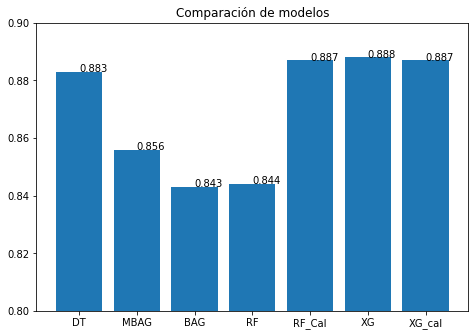

In [19]:
# Celda 8

# acc_dt, acc_mbag, acc_bag, acc_RF, acc_RF_cal, acc_XG, acc_XG_cal
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['DT','MBAG', 'BAG', 'RF','RF_Cal','XG', 'XG_cal']
n_dec = 3
ejeY = [np.round(acc_dt,n_dec), np.round(acc_mbag,n_dec), np.round(acc_bag,n_dec), 
        np.round(acc_RF,n_dec), np.round(acc_RF_cal,n_dec), np.round(acc_XG,n_dec), np.round(acc_XG_cal,n_dec)]
ax.bar(ejeX, ejeY)
def addlabels(x,y,plotP):
    for i in range(len(ejeX)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
#plt.yticks([0.5, 0.7])
plt.ylim(0.8, 0.9)
plt.show()